# Imputation of scRNA-seq data
## Data

In this R Notebook, we illustrate how to use scVAEIT on R through scRNA-seq data.
These are count data that can be modeled by (zero-inflated) Negative Binomial distribution generally.
Hypothetically, the zeros may or may not be missing; unless when integrating multiple scRNA-seq datasets, we would know which entries are missing for sure.
Below we use generate missing values to illusrate the usage of scVAEIT.


The data we use is a subset of the DOGMAseq dataset, containing B cells.

In [1]:
load("DOGMAseq-RNA.RData")

In [2]:
ls()

[1] "data"

In [3]:
data[1:5,1:5]

,X1,X3,X4,X5,X6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,0,0,0,0,0
32,0,0,0,0,0
62,0,0,0,0,0
75,0,0,0,0,0
77,0,0,0,0,0


In [4]:
dim(data)

[1]  613 2166

In [5]:
n <- nrow(data); p <- ncol(data)
data <- as.matrix(data, n, p)
data <- data[, colSums(data)>0]; # remove all-0 columns

comp.rna <- data
ij.na <- matrix(rbinom(n*p,prob=0.3,size=1),nrow=n) == 1
raw.rna <- comp.rna
raw.rna[ij.na] <- NA

# prepare input data for VAEIT
data <- raw.rna; data[is.na(data)] <- 0.;
masks <- - as.matrix(is.na(as.matrix(raw.rna)))

## Loading Python Package from R

In [6]:
# import Python package (call after setting up python environment with reticulate)
# Use 'reticulate' to access Python environment
library(reticulate)
use_condaenv(condaenv = "tf")
Sys.setenv(PYTHONUNBUFFERED = TRUE)
# If the package is installed via PyPI in the Python environment,
# simply import it:
# scVAEIT <- import("scVAEIT")
# Otherwise, need to downloaded Github repo, set a proper path to import the module.
setwd('../../../../')
scVAEIT <- import("scVAEIT")
cat("scVAEIT version:", scVAEIT$`__version__`, "\n")

scVAEIT version: 1.1.0 


## Initialize scVAEIT model

In [7]:
config = list(
# A network stucture of 
# x     :              dim_input -> 64 -> 16 -> z 4 -> 16 -> 64 -> dim_input
#                                 |             |
# masks : dim_input -> dim_embed ->             ->
    'dimensions'=c(16), # hidden layers
    'dim_latent'=4L,    # latent space

    # Block structure for the input and output layer
    'dim_block_enc'=c(64),
    'dim_block_dec'=c(64),
    'dist_block'=list('NB'), # use Gaussian likelihood by default

    'dim_block_embed'=128L,

    # some hyperparameters
    'beta_unobs'=0.9,

    # prob of random maskings
    "p_feat"=0.5
)
scVAEIT$reset_random_seeds(as.integer(0))

cat('Initializing model...\n')
model <- scVAEIT$VAEIT(config, data, masks)

Initializing model...


In [8]:
model$config

namespace(beta_kl=2.0, beta_unobs=0.9, beta_reverse=0.0, beta_modal=array([1.], dtype=float32), p_modal=None, p_feat=0.5, uni_block_names=array(['M-0'], dtype='<U23'), block_names=array(['M-0'], dtype='<U23'), dist_block=array(['NB'], dtype='<U2'), dim_block=array([2166], dtype=int32), dim_block_enc=array([64], dtype=int32), dim_block_dec=array([64], dtype=int32), skip_conn=False, mean_vals=<tf.Tensor: shape=(2166,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, min_vals=<tf.Tensor: shape=(2166,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, max_vals=<tf.Tensor: shape=(2166,), dtype=float32, numpy=
array([6.354844, 6.354844, 6.354844, ..., 6.354844, 6.354844, 6.354844],
      dtype=float32)>, max_disp=6.0, max_zi_prob=None, gamma=0.0, dimensions=array([16], dtype=int32), dim_latent=4, dim_block_embed=array([128], dtype=int32), dim_input_arr=array([2166], dtype=int32))

## Model training and inference

In [9]:
hist <- model$train(num_epoch=1000, verbose=FALSE)

# Save model if needed
# model$save_model('example/result/R/checkpoint/')

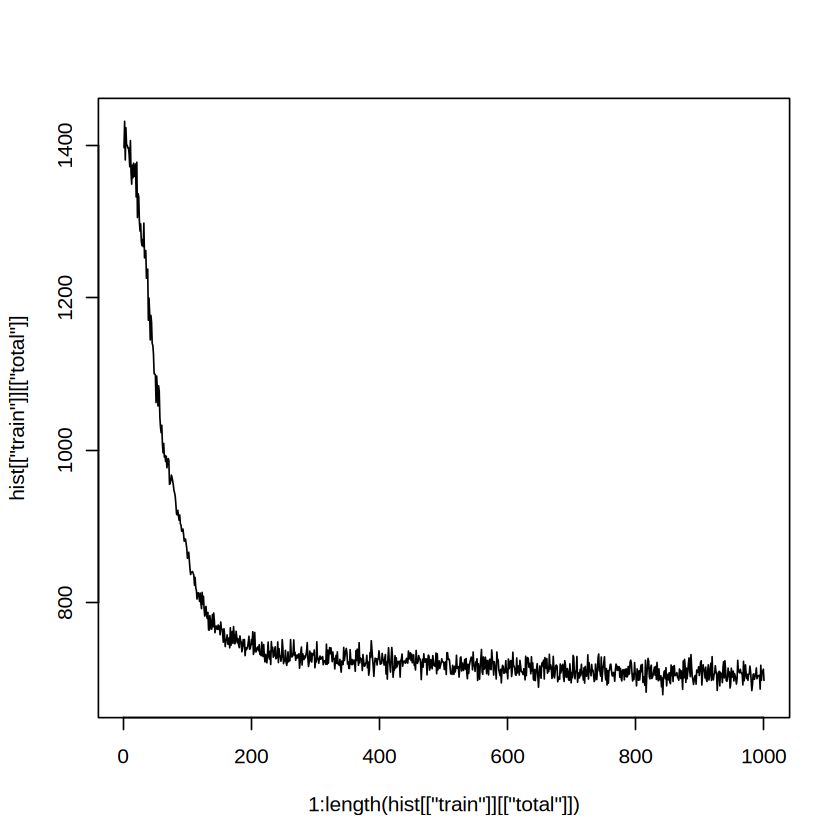

In [10]:
plot(1:length(hist[['train']][['total']]), hist[['train']][['total']], type="l")

After the model is trained, we can get impouted and denoised abundances:

In [11]:
imp.rna <- model$get_denoised_data(return_mean=TRUE)

One can also use pulgin estimate (only the missing values are imputed):

In [12]:
blend.rna <- data
ina <- masks!=0
blend.rna[ina] <- imp.rna[ina]
rownames(blend.rna) <- rownames(data)
colnames(blend.rna) <- colnames(data)

## Visualize

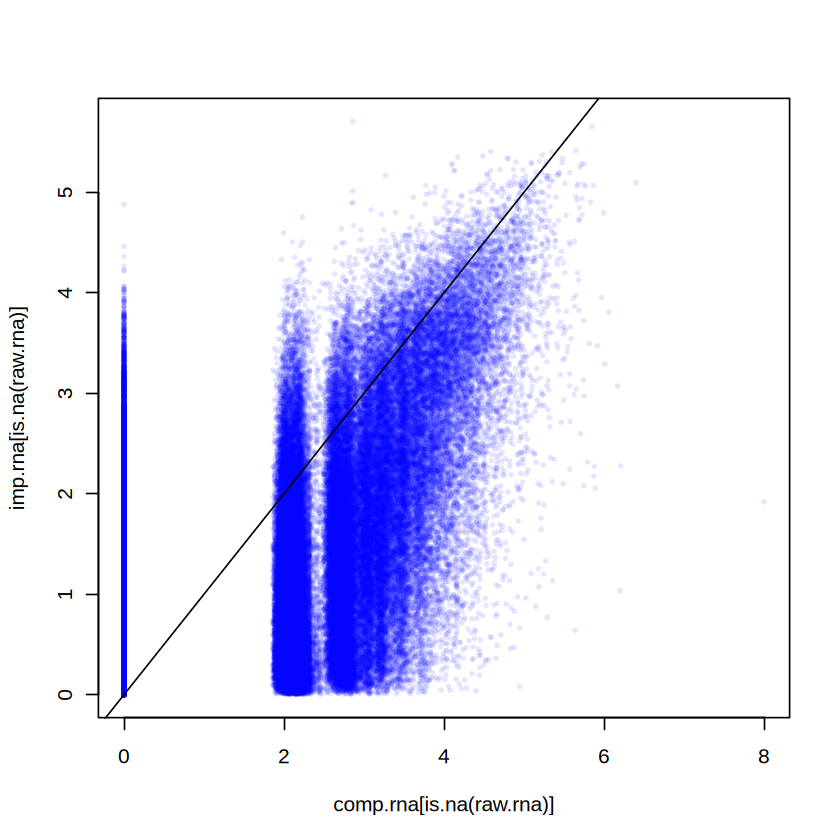

In [13]:
plot(comp.rna[is.na(raw.rna)], imp.rna[is.na(raw.rna)], 
     pch = 16, cex = .5, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.1))
abline(0,1)

In [14]:
cat(mean(((comp.rna - imp.rna)**2)[is.na(raw.rna)]))

0.80719

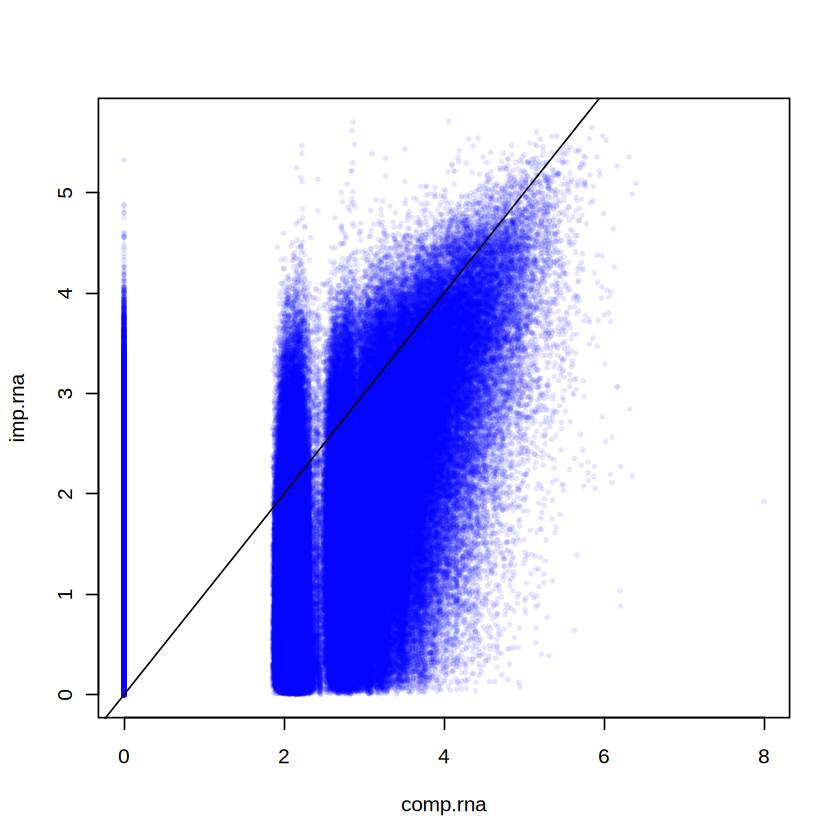

In [15]:
plot(comp.rna, imp.rna,
     pch = 16, cex = .5, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.1)
)
abline(0,1)

## R function interface

When the above procedure works properly, it is convenient to have a simple interface to iteratively the same procedure and to tune over different hyperparameters.
For this purpose, we can create a wrapper function as R file (e.g. `"R_wrapper.R"` in the current directory) and load the wrapper function in any R program by the following commands:

```r
source("R_wrapper.R")
```

When using the above command, ***make sure to use the correct path, or set up the workspace path properly.***